In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt

import scipy.optimize as opt
from scipy import stats

from tqdm import tqdm

# these functions are within the 'inorg_b' helper module.
from inorg_b import load
from inorg_b.model import predfn, fitfn
from inorg_b.plots import model_vs_data
from inorg_b.helpers import A11_2_d11, d11_2_A11, err

import corner

In [2]:
plt.rcParams['figure.dpi'] = 150

# Load Data

In [3]:
rd = load.processed(alpha_sol=1.026)

# Model fitting

## Prepare model variables for fit

In [4]:
# prepare fitting variables
cind = idx[:, 'Uchikawa', :]

# Precipitation Rate
logRp = (rd.loc[cind, ('Solid', 'logR')]).values
Rp = 10**logRp
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rd.loc[cind, ('pitzer', 'BOH3')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rd.loc[cind, ('pitzer', 'BOH4_free')] / rd.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rd.loc[cind, ('pitzer', 'B')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(rd.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values)
ABO4 = d11_2_A11(rd.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = rd.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rd.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rd.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# Uncertainties on the measured variables
LambdaB_err = err(rd.loc[cind, ('Solid', 'LambdaB_eprop')].values)
EpsilonB_err = err(rd.loc[cind, ('Solid', 'EpsilonB_eprop')].values)

# normalised to their mean, to make them comparable
LambdaB_err_norm = (LambdaB_err / LambdaB_err.mean())
EpsilonB_err_norm = (EpsilonB_err / EpsilonB_err.mean())

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

## Parameter Optimisation

Use a Non-Linear Least Square Nelder-Mead algorithm to find the optimal parameters of $^3K_b$, $^3K_f$, $^4K_b$, $^4K_f$, and $\log_{10}(R_b)$. The absolute optimised parameter values are sensitive to the starting state of the optimisiation ($x_0$). This initial 'rough' fitting served to provide 'ball-park' parameter values, ignoring the measurement uncertainties.

In [5]:
# note parameter order: (Kb3, Kf3, Kb4, Kf4, logRb)
initial_guess = (30, 0.5, 6000, 5, -6.22)

In [6]:
fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

Optimization terminated successfully.
         Current function value: 2.155198
         Iterations: 11
         Function evaluations: 668


In [7]:
fitp = fit.x

In [8]:
np.save('fit_params', fit.x)

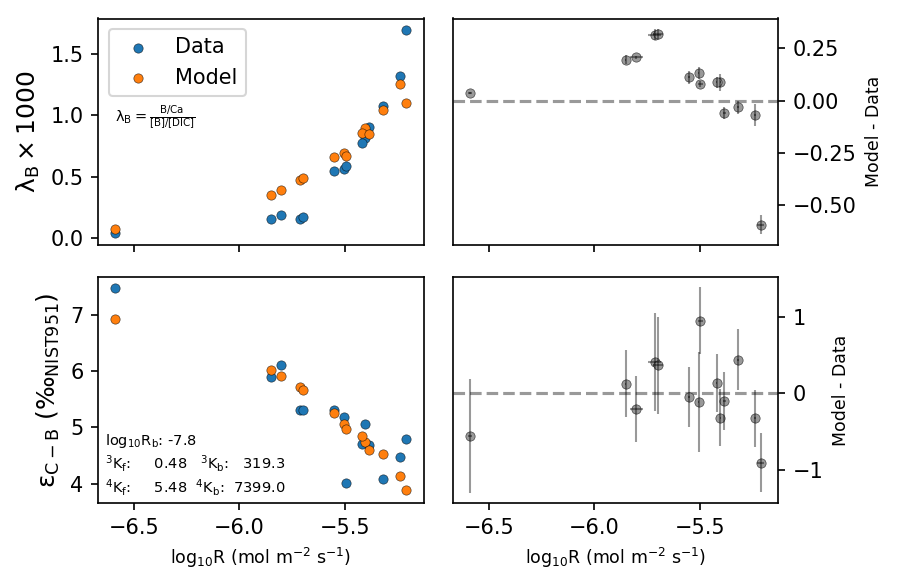

In [9]:
fig, axs = model_vs_data(fit.x, rd)

## Bootstrap Parameter Uncertainties

Calculate Parameter 95% confidence intervals by Bootstrap uncertainty resampling.

In [10]:
n = 10000
# change to True to run bootstrap calculation. Otherwise, loads results of last from file.
run_bootstrap = False

In [11]:
# Warning - this runs at ~30 iterations/second on a dual core i7 processor.
# Might take a while if n is high (10000 = ~5 min)

if run_bootstrap:
    # initialise variables for outputs
    fits = []

    # for reproducibility purposes, set the random state
    np.random.seed(42)
    # initialise iterative initial guess parameter with previous best fit
    initial_guess = fit.x
    i_initial_guess = initial_guess

    # bootstrap resampling and fitting
    for i in tqdm(range(n), total=n):
        # resample the uncertainties in the data and create new data to fit
        i_LambdaB = LambdaB + np.random.randn(LambdaB.size) * LambdaB_err
        i_EpsilonB = EpsilonB + np.random.randn(EpsilonB.size) * EpsilonB_err
        # Note: there are uncertainties in other parameters, but they are relatively
        # small compared to the B measurement errors, so we haven't included these.

        success = False  # flag indicating fit convergence.
        while not success:  # while loop catches failed model fits.
            # modify initial guess in each iteration
            # check to keep initial logRb starting point in reasonable bounds, and all starting Ks > 0.
            logRb = 0
            while ((logRb < -8.2) | (logRb > -5.2)) & all(i_initial_guess[:-1] > 0):
                i_initial_guess = initial_guess * np.random.normal(1, [.25, .25, .25, .25, .1])
                logRb = i_initial_guess[-1]

            # fit the resampled data with a random starting parameter set and initial guess
            i_fit = opt.minimize(fitfn, x0=i_initial_guess, 
                                 method='Powell', options={'maxiter': 4000},
                                 args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                                       i_LambdaB, i_EpsilonB, 1, 1, lambda_bias))
            
            # check to make sure the fit has converged, and that converged logRp is reasonable
            success = i_fit.success & (i_fit.x[-1] < -4.2) & (i_fit.x[-1] > -9.2)
            
        # record the optimised parameters.
        fits.append(i_fit.x)

    fits = np.array(fits)
        
    # save bootstrap output to save time later
    np.save('bootstrap', fits)
    
else:
    fits = np.load('bootstrap.npy')

In [12]:
# calculate parameter confidence intervals
CI_limit = 95
loq, hiq = np.apply_along_axis(np.percentile, 0, fits, q=[50 - CI_limit / 2, 50 + CI_limit / 2])

med = np.apply_along_axis(np.percentile, 0, fits, q=50)

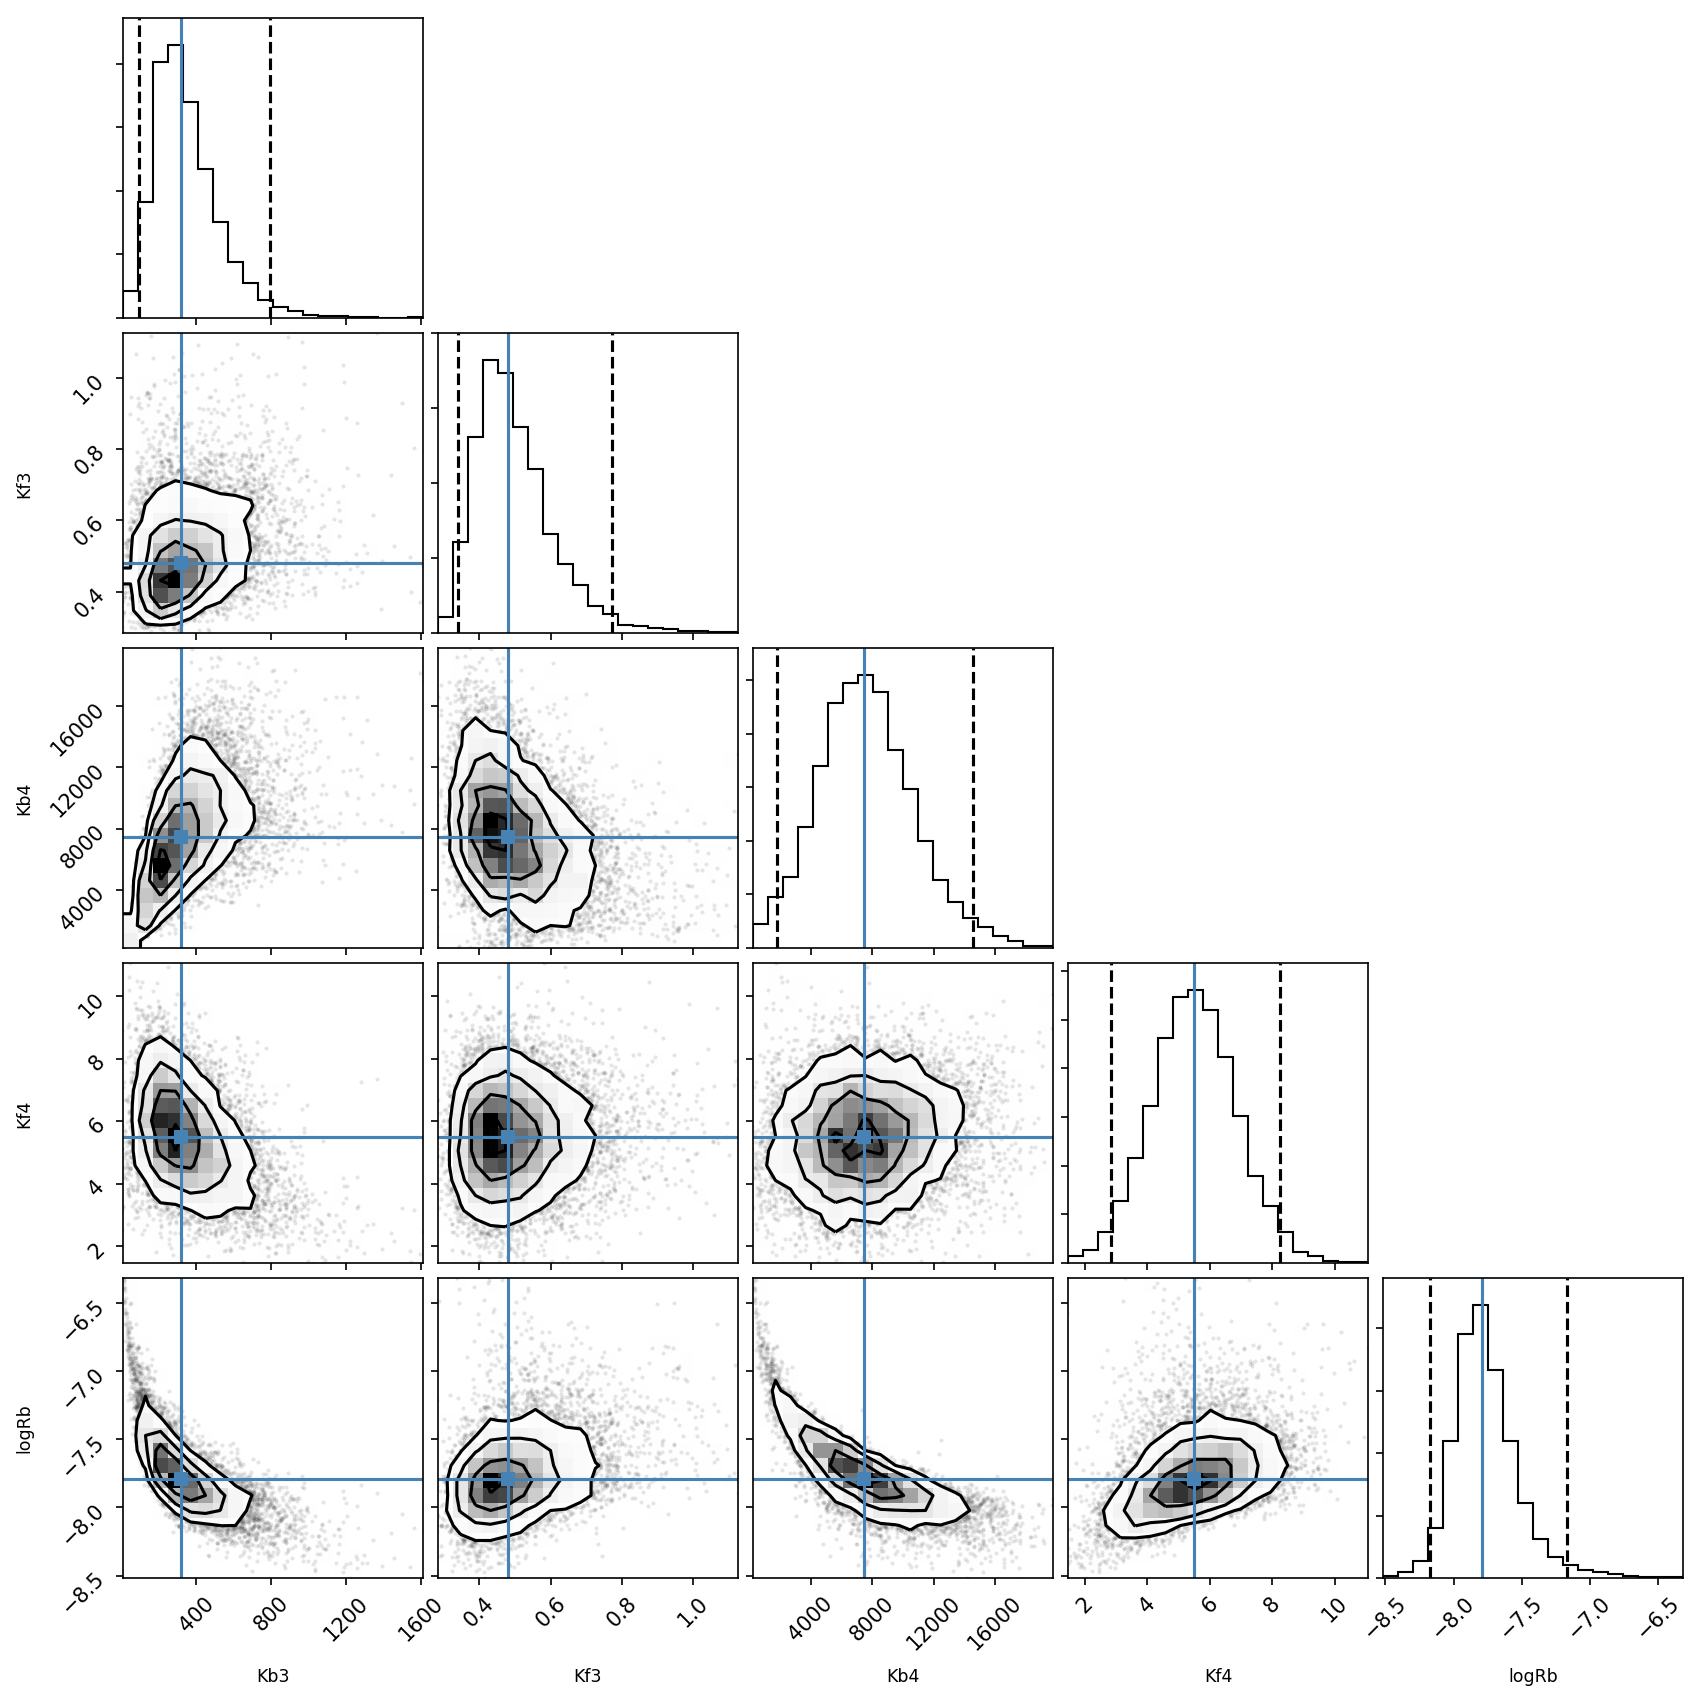

In [13]:
# plot fitted parameters and confidence intervals
par = ['Kb3', 'Kf3', 'Kb4', 'Kf4', 'logRb']
ranges = np.apply_along_axis(np.percentile, 0, fits, q=[.1, 99.9]).T
p = corner.corner(fits, labels=par, truths=med, 
                  quantiles=[(50 - CI_limit / 2) / 100, (50 + CI_limit / 2) / 100],
                  range=ranges)

In [14]:
# calculate model for each parameter combination
lam = []
eps = []

Rps = np.sort(Rp)

for p in fits:
    tlam, teps = predfn(*p,
                        Rp=Rp, rL3=rL3, rL4=rL4, B_DIC=B_DIC, ABO3=ABO3, ABO4=ABO4, dBO4=dBO4)
    
    lam.append(tlam)
    eps.append(teps)

lam = np.array(lam)
eps = np.array(eps)

# calculate 95% intervals for each point
lams = np.apply_along_axis(np.percentile, 0, lam, q=[2.5,50,97.5])
epss = np.apply_along_axis(np.percentile, 0, eps, q=[2.5,50,97.5])

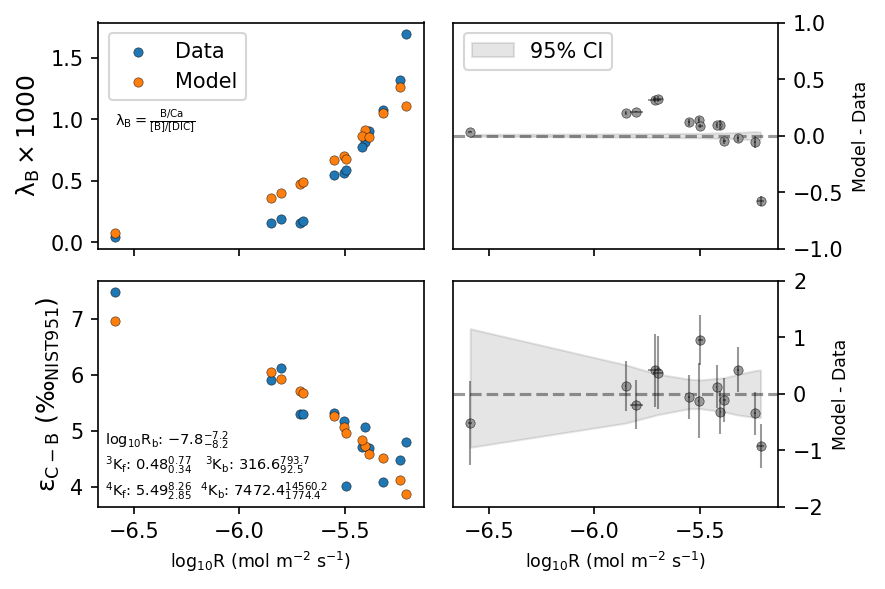

In [15]:
fig, axs = model_vs_data(med, rd, param_CIs=np.vstack([loq, hiq]).T)

((ax1, rx1), (ax2, rx2)) = axs

# 95% credible limits on residual plots
ind = np.argsort(logRp)

rx1.fill_between(logRp[ind],
                 (lams[2] - lams[1])[ind],
                 (lams[0] - lams[1])[ind],
                 color=(0,0,0,0.1), zorder=-1, label='95% CI')
rx1.legend(loc='upper left')

rx2.fill_between(logRp[ind], 
                 (epss[2] - epss[1])[ind],
                 (epss[0] - epss[1])[ind],
                 color=(0,0,0,0.1), zorder=-1)

rx1.set_ylim(-1,1)
rx2.set_ylim(-2.,2.)

fig.savefig('../../Figures/Fig5-model_vs_data.pdf')

# $\lambda_B$ residual as fn of Solution Chemistry

The largest divergence between measured data and model predictions is in $\lambda_B$, where there is a systematic pattern in the residuals. This implies the existence of a process that is not parameterised in the model. To explore what this process might be, we'll look at the $\lambda_B$ residuals as a function of all known solution / crystal growth parameters.

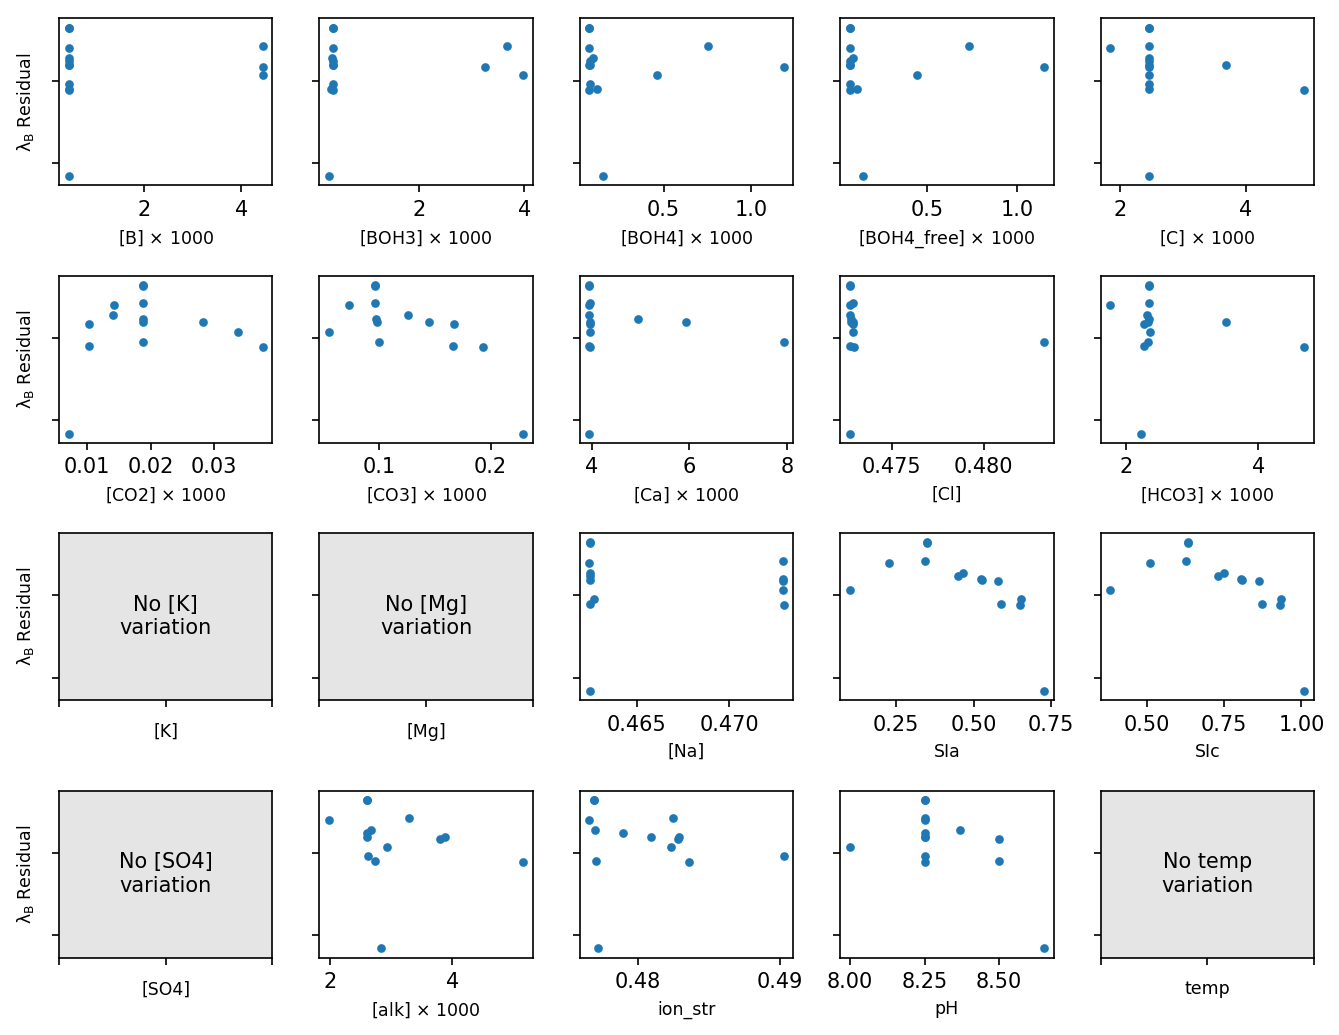

In [16]:
fig, axs = plt.subplots(4, 5, figsize=[9,7], sharey=True)

LambdaB_pred, EpsilonB_pred = predfn(*med, Rp=Rp, rL3=rL3, rL4=rL4, B_DIC=B_DIC, ABO3=ABO3, ABO4=ABO4, dBO4=dBO4)

resid = LambdaB_pred - LambdaB

notconc = ['SIa', 'SIc', 'ion_str', 'pH', 'temp']

for c, ax in zip(rd.pitzer.columns, axs.flat):
    x = rd.loc[cind, ('pitzer', c)]
    
    if c not in notconc:
        lab = '[' + c + ']'
    else:
        lab = c
    
    if x.ptp() > 0:
        m = None
        if x.ptp() < 0.01:
            m = 1e3
            x *= m
        if m is not None:
            lab = lab + ' $\\times$ {:.0f}'.format(m)
        else:
            lab = lab
    
        ax.scatter(x, resid, s=10)
    else:
        ax.axes.set_facecolor((0,0,0,0.1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(.5, .5, 'No ' + lab + '\nvariation', ha='center', va='center', transform=ax.transAxes)
        
    ax.set_xlabel(lab)
    
    if x.ptp() > 0:
        pad = x.ptp() * 0.05
        ax.set_xlim(x.min() - pad, x.max() + pad)
    
    if ax.is_first_col():
        ax.set_ylabel('$\lambda_B$ Residual')

fig.tight_layout()

fig.savefig('../../Figures/S2_Residuals.pdf')

The only coherent pattern in the residuals is with precipitation-related parameters (e.g. aspects of the C system, or SI). Thus, it is likely that there is some other minor process that alters the partitioning of B. This may be attributable to subtelties of ion-by-ion growth, which are not captured by the SKM, for example the availability of anion binding sites on the growth surface, which is more related to $[Ca^{2+}]/[CO_3^{2-}]$ than string rate-controlling parameters (Nielsen et al, 2012; 2013). If true, this should be evident in a trend in the residuals with this solution ratio. 

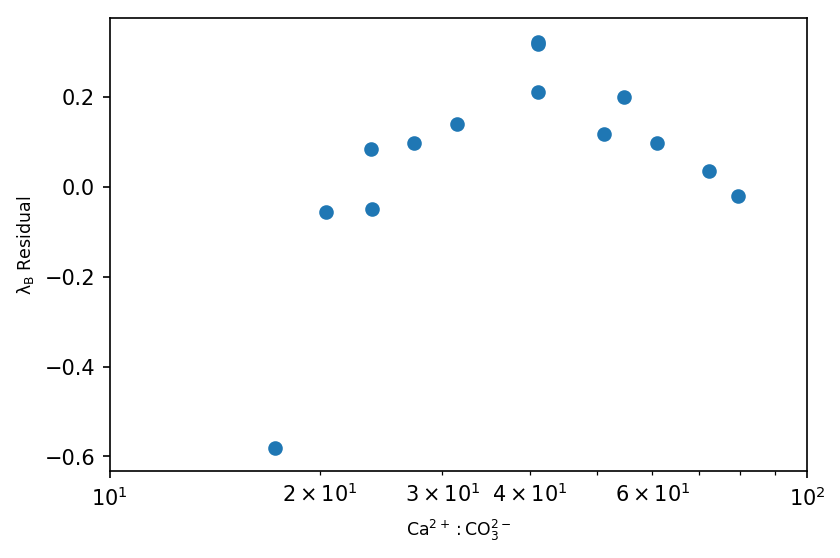

In [17]:
x = (rd.loc[cind, ('pitzer', 'Ca')] / rd.loc[cind, ('pitzer', 'CO3')]).astype(float)

fig, ax = plt.subplots(1, 1)

ax.scatter(x, resid)
ax.set_xlabel('$Ca^{2+}:CO_3^{2-}$')
ax.set_ylabel('$\lambda_B$ Residual')

ax.set_xscale('log')
ax.set_xticks([10, 100])

fig.savefig('../../Figures/S3_CaCO3_residual.pdf')

There *is* a relationship between the residuals and solution $[Ca^{2+}]/[CO_3^{2-}]$. Interestingly, this relationship has a similar form to the relationship between $[Ca^{2+}]/[CO_3^{2-}]$ and step velocity on the growing crystal surface, predicted by Nielsen et al (2012)'s ion-by-ion growth model. This *could* suggest that ion-ion interactions not included in our model may be able to account for the pattern in the $\lambda_B$ residuals. However, it is not feasible to apply an ion-by-ion growth model to B at this stage, as it requires detailed knowledge of the interaction of individual B species with the growth surface, which is currently lacking.

## Caveat: B Fractionation During Incorporation

All of the above assumes that there is no isotope fractionation during the adsorption or incorporation of either B species.

Studies of B adsorption (Saldi et al, in press) and the chemical state of B within calcite (Balan et al, 2017) at thermodynamic equilibrium have suggested that species-specific isotope fractionation *does* occur during B incorporation. Additionally, Saldi et al (in press) suggested that B(OH)3 does not interact with the calcite surface, and that only isotopically fractionation B(OH)4 is incorporated. At face value, these results directly contradict the two key assumptions in our model:

1. That both B(OH)4 and B(OH)3 interact with the surface.
2. That neither species is fractionated during incorporation.

However, we would argue that our experiments, and the studies of Saldi et al (in press) and Balan et al (2017) examine fundamentally different precipitation regimes - theirs focus on equilibrium conditions, and ours focus on kinetically-dominated precipitation processes.

Nevertheless, it is possible to test the possibility of both B fractionation, and sole B(OH)4 incorporation within the framework of our model. We will examine two key scenarios:

1. Sole B(OH)4 incorporation with an unconstrained, fitted fractionation parameter.
2. Incorporation of both species, with unconstrained, fitted fractionation parameters for each species.


### 1. Sole B(OH)4 incorporation with fractionation

In [18]:
from inorg_b.model import predfn_single_species, fitfn_single_species

In [19]:
# prepare fitting variables
cind = idx[:, 'Uchikawa', :]

# Precipitation Rate
logRp = (rd.loc[cind, ('Solid', 'logR')]).values
Rp = 10**logRp
# Solution BO4/CO3 ratios
rL4 = (rd.loc[cind, ('pitzer', 'BOH4_free')] / rd.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rd.loc[cind, ('pitzer', 'B')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
# Borate d11B
dBO4 = rd.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rd.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rd.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

In [20]:
initial_guess = (2000, 200, -6.22, 0)

fit = opt.minimize(fitfn_single_species, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL4, B_DIC, dBO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

Optimization terminated successfully.
         Current function value: 5.800654
         Iterations: 12
         Function evaluations: 748


In [21]:
print('Optimised Parameters:\nKb4: {:.2f}\nKf4: {:.2f}\nlogRb: {:.2f}\nepsilon_4: {:.2f}'.format(*fit.x))

Optimised Parameters:
Kb4: 23314.98
Kf4: 41.92
logRb: -7.47
epsilon_4: 5.17


Interestingly, the fitted epsilon parameter is ~5 permil, in line with Saldi et al's (in press) estimate of fractionation associated with B(OH)4 adsorption.

In [22]:
plam, peps = predfn_single_species(*fit.x, Rp, rL4, B_DIC, dBO4, dBO4)

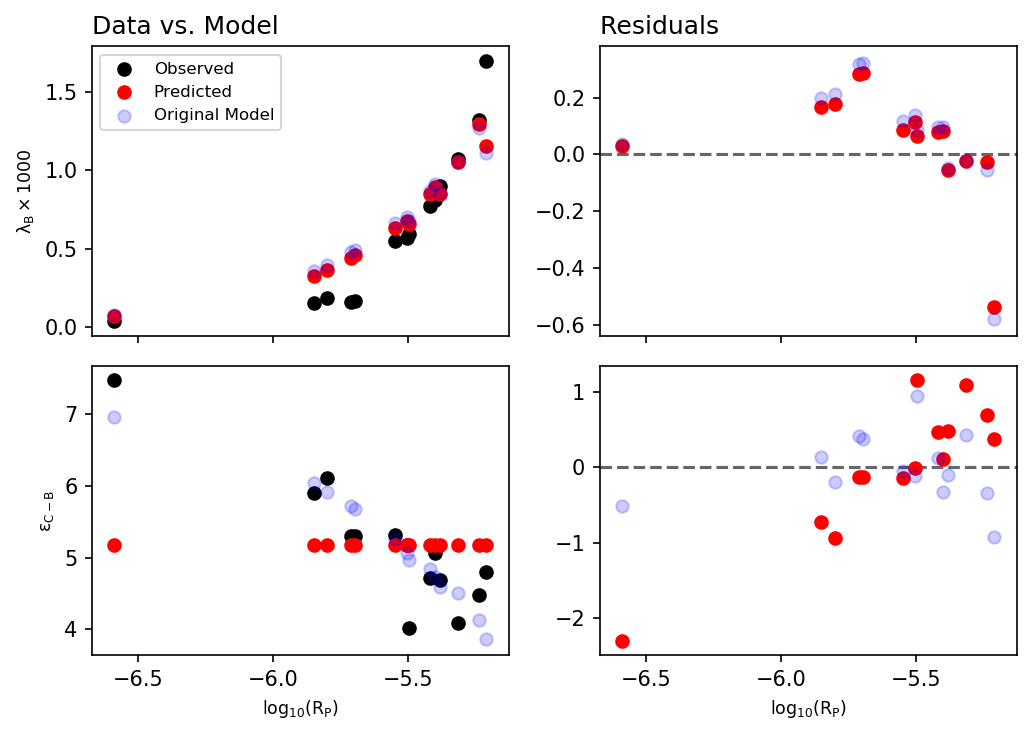

In [23]:
fig, ((ax1, rax1), (ax2, rax2)) = plt.subplots(2, 2, figsize=[7,5], sharex=True)

ax1.scatter(logRp, LambdaB, c='k', label='Observed')
ax1.scatter(logRp, plam, c='r', label='Predicted')
ax1.scatter(logRp, LambdaB_pred, c='b', alpha=0.2, label='Original Model')
rax1.scatter(logRp, plam - LambdaB, c='r')
rax1.scatter(logRp, LambdaB_pred - LambdaB, c='b', alpha=0.2)

ax2.scatter(logRp, EpsilonB, c='k')
ax2.scatter(logRp, peps, c='r')
ax2.scatter(logRp, EpsilonB_pred, c='b', alpha=0.2)
rax2.scatter(logRp, peps - EpsilonB, c='r')
rax2.scatter(logRp, EpsilonB_pred - EpsilonB, c='b', alpha=0.2)

for rx in [rax1, rax2]:
    rx.axhline(0, ls='dashed', zorder=-1, alpha=0.6, c='k')
    
for ax in [ax2, rax2]:
    ax.set_xlabel('$log_{10}(R_P)$')

ax1.set_ylabel('$\lambda_B \\times 1000$')
ax2.set_ylabel('$\epsilon_{C - B}$')

ax1.legend(fontsize=8)

ax1.set_title('Data vs. Model', loc='left')
rax1.set_title('Residuals', loc='left')

fig.tight_layout()

Also, this model is able to fit the partitioning data equivilently well with sole B(OH)4 incorporation. However, this model is unable to produce the observed trend in $\epsilon_{C-B}$ with precipitation rate.

### 2. Both species, with fitted fractionation parameters

In [24]:
from inorg_b.model import predfn_fractionated, fitfn_fractionated

In [25]:
# prepare fitting variables
cind = idx[:, 'Uchikawa', :]

# Precipitation Rate
logRp = (rd.loc[cind, ('Solid', 'logR')]).values
Rp = 10**logRp
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rd.loc[cind, ('pitzer', 'BOH3')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rd.loc[cind, ('pitzer', 'BOH4_free')] / rd.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rd.loc[cind, ('pitzer', 'B')] / rd.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
dBO3 = rd.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values
dBO4 = rd.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rd.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rd.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

In [26]:
initial_guess = np.concatenate([fitp, [0, 0]])

fit = opt.minimize(fitfn_fractionated, x0=initial_guess,
                   method='Powell', options={'maxiter': 200000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, dBO3, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

Optimization terminated successfully.
         Current function value: 1.542141
         Iterations: 23
         Function evaluations: 1856


In [27]:
print('Optimised Parameters:\nKb3: {:.2f}\nKf3: {:.2f}\nKb4: {:.2f}\nKf4: {:.2f}\nlogRb: {:.2f}\nepsilon_3: {:.2f}\nepsilon_4: {:.2f}'.format(*fit.x))

Optimised Parameters:
Kb3: 231.73
Kf3: 0.06
Kb4: 13379.60
Kf4: 3.48
logRb: -8.33
epsilon_3: 10.01
epsilon_4: 3.49


The B(OH)4 fractionation parameters is ~3.5, in the same ballpark as adsorption fractionation observed by Saldi et al (in press). 

The B(OH)3 fractionation parameter is ~10, which is similar to that calculated for structural B by Balan et al (2017).

In [28]:
plam, peps = predfn_fractionated(*fit.x, Rp, rL3, rL4, B_DIC, dBO3, dBO4)

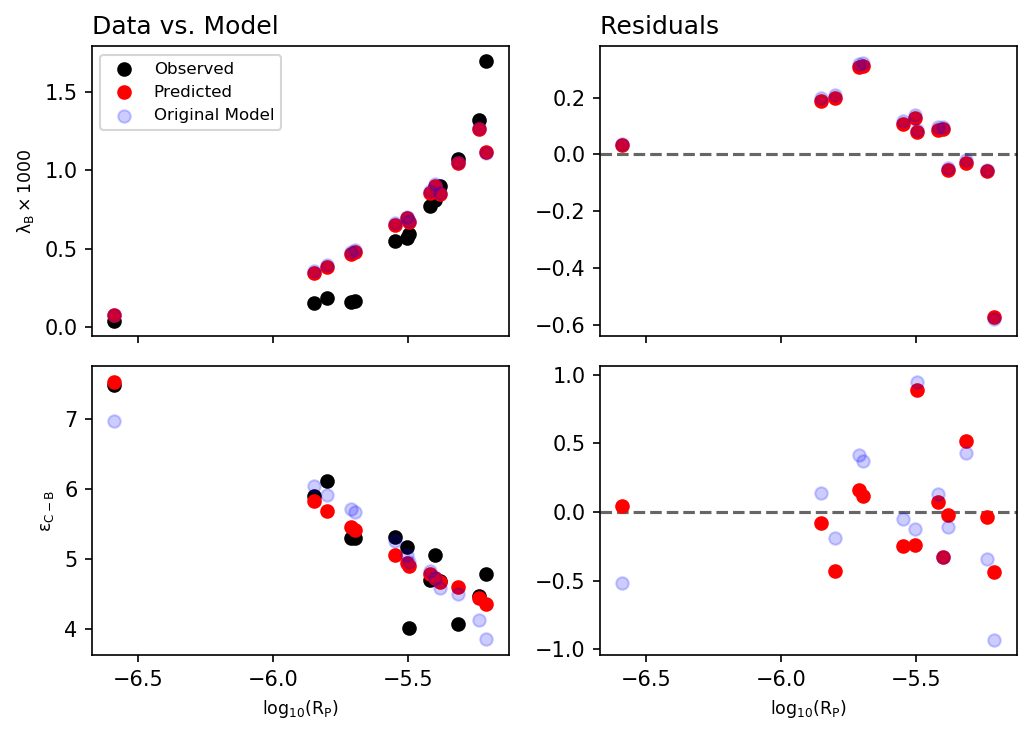

In [29]:
fig, ((ax1, rax1), (ax2, rax2)) = plt.subplots(2, 2, figsize=[7,5], sharex=True)

ax1.scatter(logRp, LambdaB, c='k', label='Observed')
ax1.scatter(logRp, plam, c='r', label='Predicted')
ax1.scatter(logRp, LambdaB_pred, c='b', alpha=0.2, label='Original Model')
rax1.scatter(logRp, plam - LambdaB, c='r')
rax1.scatter(logRp, LambdaB_pred - LambdaB, c='b', alpha=0.2)

ax2.scatter(logRp, EpsilonB, c='k')
ax2.scatter(logRp, peps, c='r')
ax2.scatter(logRp, EpsilonB_pred, c='b', alpha=0.2)
rax2.scatter(logRp, peps - EpsilonB, c='r')
rax2.scatter(logRp, EpsilonB_pred - EpsilonB, c='b', alpha=0.2)

for rx in [rax1, rax2]:
    rx.axhline(0, ls='dashed', zorder=-1, alpha=0.6, c='k')
    
for ax in [ax2, rax2]:
    ax.set_xlabel('$log_{10}(R_P)$')

ax1.set_ylabel('$\lambda_B \\times 1000$')
ax2.set_ylabel('$\epsilon_{C - B}$')

ax1.legend(fontsize=8)

ax1.set_title('Data vs. Model', loc='left')
rax1.set_title('Residuals', loc='left')

fig.tight_layout()

### 3. Incorporation of both species, sole B(OH)4 fractionation

In [30]:
from inorg_b.model import fitfn_BO4fractionated, predfn_BO4fractionated

In [31]:
initial_guess = np.concatenate([fitp, [0]])

fit = opt.minimize(fitfn_BO4fractionated, x0=initial_guess,
                   method='Powell', options={'maxiter': 200000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, dBO3, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

Optimization terminated successfully.
         Current function value: 1.567531
         Iterations: 18
         Function evaluations: 1271


In [32]:
print('Optimised Parameters:\nKb3: {:.2f}\nKf3: {:.2f}\nKb4: {:.2f}\nKf4: {:.2f}\nlogRb: {:.2f}\nepsilon_4: {:.2f}'.format(*fit.x))

Optimised Parameters:
Kb3: 358.23
Kf3: 0.09
Kb4: 21079.64
Kf4: 3.48
logRb: -8.51
epsilon_4: 3.41


The model converges with a B(OH)4 fractionation of +3.4 permil, again roughly consistent with Saldi et al's (in press) estimate of the magnitude of B(OH)4 fractionation suring adsorption.

In [33]:
plam, peps = predfn_BO4fractionated(*fit.x, Rp, rL3, rL4, B_DIC, dBO3, dBO4)

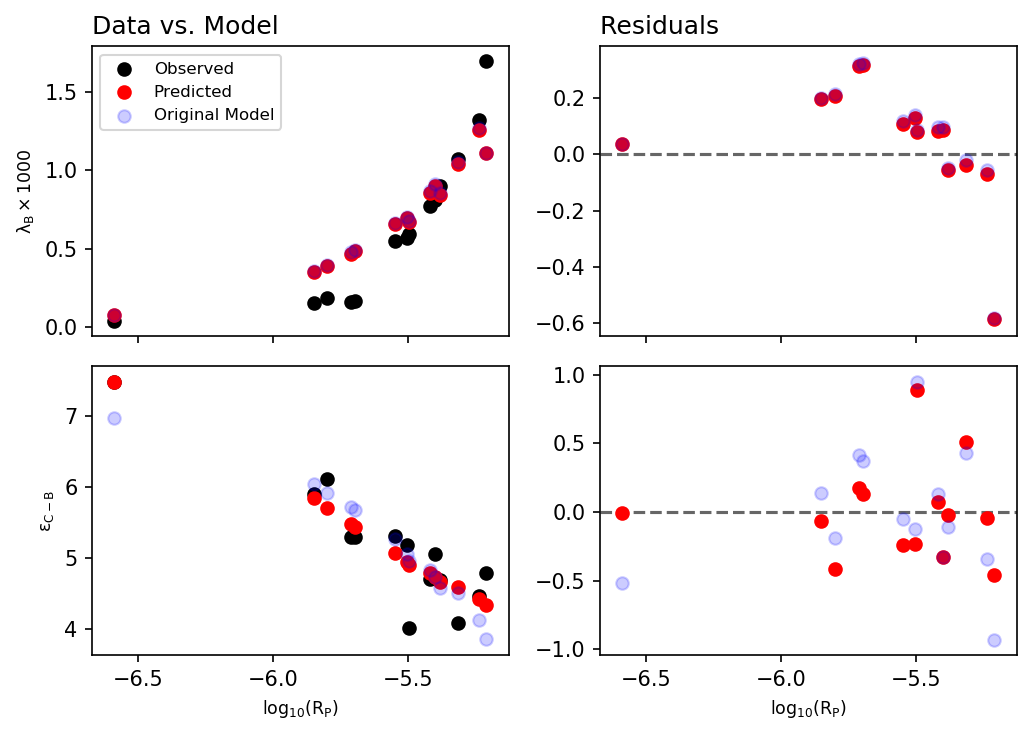

In [34]:
fig, ((ax1, rax1), (ax2, rax2)) = plt.subplots(2, 2, figsize=[7,5], sharex=True)

ax1.scatter(logRp, LambdaB, c='k', label='Observed')
ax1.scatter(logRp, plam, c='r', label='Predicted')
ax1.scatter(logRp, LambdaB_pred, c='b', alpha=0.2, label='Original Model')
rax1.scatter(logRp, plam - LambdaB, c='r')
rax1.scatter(logRp, LambdaB_pred - LambdaB, c='b', alpha=0.2)

ax2.scatter(logRp, EpsilonB, c='k')
ax2.scatter(logRp, peps, c='r')
ax2.scatter(logRp, EpsilonB_pred, c='b', alpha=0.2)
rax2.scatter(logRp, peps - EpsilonB, c='r')
rax2.scatter(logRp, EpsilonB_pred - EpsilonB, c='b', alpha=0.2)

for rx in [rax1, rax2]:
    rx.axhline(0, ls='dashed', zorder=-1, alpha=0.6, c='k')
    
for ax in [ax2, rax2]:
    ax.set_xlabel('$log_{10}(R_P)$')

ax1.set_ylabel('$\lambda_B \\times 1000$')
ax2.set_ylabel('$\epsilon_{C - B}$')

ax1.legend(fontsize=8)

ax1.set_title('Data vs. Model', loc='left')
rax1.set_title('Residuals', loc='left')

fig.tight_layout()

### Fractionation Conclusions:

Our data cannot be explained by sole $B(OH)_4^-$ incorporation with isotopic fractionation, as suggested by Saldi et al (in press). This mechanism is unable to explain the pattern in the $\epsilon_{C-B}$ residuals.

Our model fits to $\epsilon_{C-B}$ are marginally improved by including species-specific fractionation coefficients during incorporation, although there is no discernible difference between a model with sole $B(OH)_4^-$ fractionation, and including $B(OH)_3$ fractionionation.

Fractionation *may* exert an influence on our results, although we are unable to resolve the most likely mechanism from our data.

Most importantly:
1. Improvements in $\epsilon_{C-B}$ fit provided by including fractionation terms are marginal, and the relative magnitudes of the forward- and backward-partitioning coefficients for each species are not altered. This implies that the primary controlling factor influencing $\epsilon_{C-B}$ is the incorporation of both species into the mineral, and any fractionation during incorporation exerts a relatively minor influence.
2. Including fractionation does not alter the $\lambda_B$ residuals. This shows that there is still an additional, unparameterised process that the model cannot explain.